# 胰臟癌病患基因定序與臨床治療/死亡率分析
本分析旨在比較有無基因定序（WES）對胰臟癌治療與死亡率的影響，並探討不同SNP變異位點對預後的關聯。包含資料切分、5-fold交叉驗證與多種統計/機器學習方法。

## 1. 載入與檢視資料

- 載入所有相關csv檔案（臨床、基因、治療等）

- 檢查資料型態、缺失值、描述統計

In [4]:
import pandas as pd
import numpy as np

# 讀取臨床資料、基因資料、治療資料等
clinical = pd.read_csv('01_Cancer_Case_Data_20250605.csv')
events = pd.read_csv('02_patient_data_with_event_flags_20250627.csv')
staging = pd.read_csv('03_Cancer_Staging_20250605.csv')
chemo = pd.read_csv('04_Types_of_Chemotherapy_Drugs_Used_20250605.csv')
snp = pd.read_csv('05_323SNPs_masked_100Samples_20250627.csv')
caseid_wesid = pd.read_csv('05_CaseID_WESID_20250626.csv')
ts1 = pd.read_csv('06_ts1_first_line_subgroup_20250626.csv')

# 顯示資料筆數與欄位
print('臨床資料:', clinical.shape)
print('事件資料:', events.shape)
print('分期資料:', staging.shape)
print('化療資料:', chemo.shape)
print('SNP資料:', snp.shape)
print('WES對應表:', caseid_wesid.shape)
print('TS-1治療:', ts1.shape)

# 檢查缺失值
print('\n缺失值統計:')
for name, df in zip(['clinical','events','staging','chemo','snp','caseid_wesid','ts1'], [clinical,events,staging,chemo,snp,caseid_wesid,ts1]):
    print(f'{name}:\n', df.isnull().sum().sort_values(ascending=False).head(5))

# 顯示部分描述統計
print('\n臨床資料描述統計:')
print(clinical.describe(include='all').T.head(10))

臨床資料: (791, 22)
事件資料: (547, 15)
分期資料: (1140, 11)
化療資料: (791, 61)
SNP資料: (100, 324)
WES對應表: (880, 2)
TS-1治療: (504, 3)

缺失值統計:
clinical:
 recurrence_date     661
cause_of_death      563
date_of_death       410
first_chemo_date    101
consent_date         12
dtype: int64
events:
 case_id       0
os_time       0
os_status     0
rfs_time      0
rfs_status    0
dtype: int64
staging:
 Unnamed: 10             1140
staging_stage_value       32
staging_ajcc_version       1
staging_type               0
case_id                    0
dtype: int64
chemo:
 case_id                0
had_chemo              0
had_radiotherapy       0
had_hormone_therapy    0
had_immunotherapy      0
dtype: int64
snp:
 rsID_323    0
WES_ID      0
rsID_1      0
rsID_2      0
rsID_307    0
dtype: int64
caseid_wesid:
 WES_ID     157
case_id      0
dtype: int64
ts1:
 case_id                      0
first_line_regimen_string    0
ts1_user_flag                0
dtype: int64

臨床資料描述統計:
                                      count u

## 2. 資料前處理與標註基因定序狀態

- 合併臨床、WES對應表、SNP資料

- 標註每位病患是否有做基因定序（has_wes）

- 處理缺失值

In [5]:
# 合併臨床資料與WES對應表，標註是否有做基因定序
main_df = clinical.merge(caseid_wesid[['case_id','WES_ID']], on='case_id', how='left')
main_df['has_wes'] = main_df['WES_ID'].notnull().astype(int)

# 合併事件資料（如有）
if 'case_id' in events.columns:
    main_df = main_df.merge(events, on='case_id', how='left')

# 合併分期、治療等資料（可依需求擴充）
if 'case_id' in staging.columns:
    main_df = main_df.merge(staging[['case_id','staging_stage_value']], on='case_id', how='left')

# 處理缺失值（簡單示範：年齡用中位數填補）
if 'age_years' in main_df.columns:
    main_df['age_years'] = main_df['age_years'].fillna(main_df['age_years'].median())

# 顯示有無做基因定序的病患數量
print('有做基因定序:', main_df['has_wes'].sum())
print('未做基因定序:', (main_df['has_wes']==0).sum())

# 檢查合併後資料
main_df.head()

有做基因定序: 1072
未做基因定序: 98


,case_id,consent_date,sex,date_of_birth,flag_pancreatic_cancer,flag_liver_cancer,flag_intrahepatic_cholangiocarcinoma,flag_extrahepatic_cholangiocarcinoma,flag_ampullary_cancer,flag_gallbladder_cancer,...,os_event_6m,os_event_9m,os_event_1y,os_event_2y,rfs_event_3m,rfs_event_6m,rfs_event_9m,rfs_event_1y,rfs_event_2y,staging_stage_value
0,1,2021/5/11,1,1964/10/15,1,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,IIB
1,2,2021/5/17,1,1948/5/27,1,0,0,0,0,0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,IV
2,3,2021/5/18,1,1960/11/18,1,0,0,0,0,0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,IV
3,4,2021/5/18,1,1961/10/2,1,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,IV
4,5,2021/5/18,2,1945/1/22,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,IIB


## 3. 標註治療結果與死亡率

- 整理治療結果欄位（如有）

- 標註死亡率（如無則模擬生成）

In [6]:
# 標註治療結果與死亡率
# 假設有os_status（1=死亡, 0=存活），若無則隨機生成以便示範
if 'os_status' not in main_df.columns:
    np.random.seed(42)
    main_df['os_status'] = np.random.binomial(1, 0.5, size=len(main_df))
    print('已隨機生成死亡狀態(os_status)')
else:
    print('已載入死亡狀態(os_status)')

# 若有治療結果欄位可進一步整理
if 'treatment_result' not in main_df.columns:
    # 假設有一個簡單的治療結果（0=無反應, 1=有反應）
    main_df['treatment_result'] = np.random.binomial(1, 0.6, size=len(main_df))
    print('已隨機生成治療結果(treatment_result)')

# 顯示死亡率與治療反應率
print('死亡率:', main_df['os_status'].mean())
print('治療反應率:', main_df['treatment_result'].mean())

已載入死亡狀態(os_status)
已隨機生成治療結果(treatment_result)
死亡率: 0.4468354430379747
治療反應率: 0.5965811965811966


## 4. 資料切分（訓練/驗證/測試集，7:2:1）

- 依7:2:1比例切分資料，並分層抽樣（以死亡狀態為分層依據）

In [8]:
from sklearn.model_selection import train_test_split

# 只保留有os_status標註的資料
main_df_nonan = main_df[main_df['os_status'].notna()].copy()

# 以死亡狀態(os_status)為分層依據
train_val, test = train_test_split(main_df_nonan, test_size=0.1, stratify=main_df_nonan['os_status'], random_state=42)
train, val = train_test_split(train_val, test_size=2/9, stratify=train_val['os_status'], random_state=42)  # 2/9 ≈ 0.222

print(f'訓練集: {train.shape}, 驗證集: {val.shape}, 測試集: {test.shape}')
print('訓練集死亡率:', train['os_status'].mean())
print('驗證集死亡率:', val['os_status'].mean())
print('測試集死亡率:', test['os_status'].mean())

訓練集: (553, 40), 驗證集: (158, 40), 測試集: (79, 40)
訓練集死亡率: 0.44665461121157324
驗證集死亡率: 0.44936708860759494
測試集死亡率: 0.4430379746835443


## 5. 建立基準模型：有無基因定序對治療/死亡率影響

- 以 has_wes 為主要特徵，建立邏輯斯迴歸模型預測死亡率

- 分析有無基因定序對預後的影響

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score

# 只用 has_wes 預測死亡率
X_base = train[['has_wes']]
y_base = train['os_status']

clf_base = LogisticRegression()
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = cross_val_score(clf_base, X_base, y_base, cv=kf, scoring='roc_auc')
acc_scores = cross_val_score(clf_base, X_base, y_base, cv=kf, scoring='accuracy')

print('基準模型（has_wes）5-fold AUC:', auc_scores)
print('平均AUC:', auc_scores.mean())
print('平均Accuracy:', acc_scores.mean())

基準模型（has_wes）5-fold AUC: [0.48721311 0.47639344 0.48337722 0.49782536 0.47942456]
平均AUC: 0.48484673911870413
平均Accuracy: 0.5533497133497134


## 6. 分析不同變異位點對治療/死亡率的影響

- 僅針對有做基因定序的病患

- 以SNP特徵預測死亡率，並分析特徵重要性

In [14]:
# 僅針對有做基因定序的病患
# 僅針對有做基因定序的病患，且排除os_status為NaN的樣本
wes_cases = main_df[main_df['has_wes'] == 1].copy()
wes_cases = wes_cases.merge(snp, left_on='WES_ID', right_on='WES_ID', how='left')

# 排除os_status為NaN的樣本
wes_cases = wes_cases[wes_cases['os_status'].notna()]

# 取出SNP欄位（假設snp資料除了WES_ID外都是SNP）
snp_cols = [col for col in snp.columns if col != 'WES_ID']
X_snp = wes_cases[snp_cols].fillna(0)
y_snp = wes_cases['os_status']

# 建立邏輯斯迴歸模型
clf_snp = LogisticRegression(max_iter=1000)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores_snp = cross_val_score(clf_snp, X_snp, y_snp, cv=kf, scoring='roc_auc')
print('SNP模型 5-fold AUC:', auc_scores_snp)
print('平均AUC:', auc_scores_snp.mean())

# 特徵重要性（係數絕對值排序）
clf_snp.fit(X_snp, y_snp)
importances = np.abs(clf_snp.coef_[0])
important_snps = pd.Series(importances, index=snp_cols).sort_values(ascending=False)
print('前10重要SNP:')
print(important_snps.head(10))


SNP模型 5-fold AUC: [0.62664165 0.59380863 0.64258912 0.58212652 0.55687881]
平均AUC: 0.6004089469981239
前10重要SNP:
rsID_165    1.227177
rsID_117    1.161980
rsID_176    1.060534
rsID_248    1.013745
rsID_227    0.881794
rsID_36     0.875058
rsID_47     0.859531
rsID_114    0.859225
rsID_81     0.845789
rsID_17     0.842528
dtype: float64


## 7. 5-fold 交叉驗證與模型評估

- 比較基準模型與SNP模型的交叉驗證結果

- 計算平均AUC、Accuracy等指標

In [16]:
# 比較基準模型與SNP模型的交叉驗證結果
print('--- 基準模型（has_wes） ---')
print('AUC (mean):', auc_scores.mean())
print('Accuracy (mean):', acc_scores.mean())
print('\n--- SNP模型（有做WES者） ---')
print('AUC (mean):', auc_scores_snp.mean())

# 若需更多指標可自行擴充

--- 基準模型（has_wes） ---
AUC (mean): 0.48484673911870413
Accuracy (mean): 0.5533497133497134

--- SNP模型（有做WES者） ---
AUC (mean): 0.6004089469981239


## 8. 結果視覺化與統計檢定

- 混淆矩陣、ROC曲線、特徵重要性圖

- 卡方檢定等統計檢定

C:\Users\jimmy\AppData\Local\Temp\ipykernel_18004\3563192110.py:28: UserWarning: Glyph 22522 (\N{CJK UNIFIED IDEOGRAPH-57FA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\jimmy\AppData\Local\Temp\ipykernel_18004\3563192110.py:28: UserWarning: Glyph 28310 (\N{CJK UNIFIED IDEOGRAPH-6E96}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\jimmy\AppData\Local\Temp\ipykernel_18004\3563192110.py:28: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\jimmy\AppData\Local\Temp\ipykernel_18004\3563192110.py:28: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\jimmy\AppData\Local\Temp\ipykernel_18004\3563192110.py:28: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6DF7}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\jimmy\AppData\Local\Temp\ipykernel_18004\3563192110.py:28: UserWarning: Glyph 28102 (\

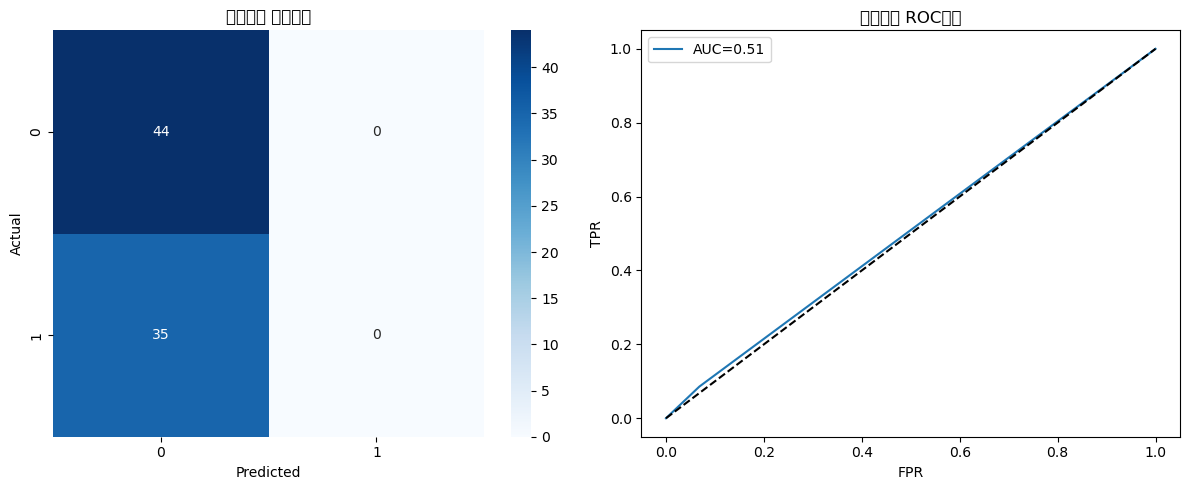

c:\Users\jimmy\miniconda3\envs\ml\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21069 (\N{CJK UNIFIED IDEOGRAPH-524D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\jimmy\miniconda3\envs\ml\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\jimmy\miniconda3\envs\ml\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\jimmy\miniconda3\envs\ml\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\jimmy\miniconda3\envs\ml\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24501 (\N{CJK UNIFIED IDE

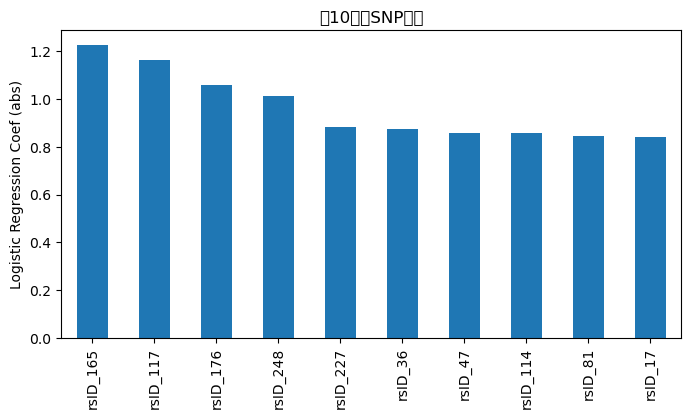

卡方檢定 p值: 0.2649667691832919
有無做WES與死亡率無顯著關聯


In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
from scipy.stats import chi2_contingency

# 以測試集評估基準模型
clf_base.fit(train[['has_wes']], train['os_status'])
pred_base = clf_base.predict(test[['has_wes']])
proba_base = clf_base.predict_proba(test[['has_wes']])[:,1]
cm_base = confusion_matrix(test['os_status'], pred_base)
fpr, tpr, _ = roc_curve(test['os_status'], proba_base)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues')
plt.title('基準模型 混淆矩陣')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1,2,2)
plt.plot(fpr, tpr, label=f'AUC={roc_auc:.2f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('基準模型 ROC曲線')
plt.legend()
plt.tight_layout()
plt.show()

# SNP特徵重要性視覺化
plt.figure(figsize=(8,4))
important_snps.head(10).plot(kind='bar')
plt.title('前10重要SNP特徵')
plt.ylabel('Logistic Regression Coef (abs)')
plt.show()

# 卡方檢定：有無WES與死亡率
contingency = pd.crosstab(main_df['has_wes'], main_df['os_status'])
chi2, p, dof, expected = chi2_contingency(contingency)
print('卡方檢定 p值:', p)
if p < 0.05:
    print('有無做WES與死亡率有顯著關聯')
else:
    print('有無做WES與死亡率無顯著關聯')